### Exploring pairs trading

trying to learn more about quant finance

using these slides for pairs trading, thx @nik_algo on twitter

https://palomar.home.ece.ust.hk/MAFS5310_lectures/slides_pairs_trading.pdf

gonna work through his slides using s&p500 company data


#### data gathering

In [2]:
import pandas as pd
import yfinance
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
table = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
symbols = ' '.join(df['Symbol'])
symbols[:100]
data = yfinance.download(
    tickers = symbols,
    period = "1y",
    interval = '1h',
    ignore_tz = True,
    prepost = False
)

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [4]:
data.head()

print(data.astype(bool).sum(axis=1).value_counts())
log_prices = data['Adj Close'].copy()
for c in log_prices.columns:
    log_prices[c] = np.log10(log_prices[c] + 0.001)
log_prices.fillna(method='backfill',inplace=True)
log_prices.dropna(axis=1,inplace=True)

3018    1631
3017      66
3016      26
3015      14
3014      11
3013       3
2966       1
3012       1
2518       1
3004       1
dtype: int64


In [5]:
print(log_prices.iloc[:5,:5])

                            A       AAL       AAP      AAPL      ABBV
2022-02-18 09:30:00  2.119507  1.256261  2.343233  2.226602  2.162687
2022-02-18 10:30:00  2.118285  1.252635  2.340605  2.225583  2.160351
2022-02-18 11:30:00  2.119193  1.254451  2.338219  2.224524  2.158230
2022-02-18 12:30:00  2.118466  1.252149  2.340109  2.221025  2.157369
2022-02-18 13:30:00  2.122907  1.257222  2.341812  2.225415  2.159089


In [6]:
print(log_prices.corr().iloc[:5,:5])

             A       AAL       AAP      AAPL      ABBV
A     1.000000 -0.001519 -0.599015 -0.150179  0.337671
AAL  -0.001519  1.000000  0.512349  0.486768  0.276492
AAP  -0.599015  0.512349  1.000000  0.692620 -0.018459
AAPL -0.150179  0.486768  0.692620  1.000000 -0.073219
ABBV  0.337671  0.276492 -0.018459 -0.073219  1.000000


#### Pair selection

In [7]:
rough_cointegration_values = []
for i,c in enumerate(log_prices.columns):
    for c1 in log_prices.columns[i + 1:]:
        diff = np.sum(np.square(log_prices[c] - log_prices[c1]))
        rough_cointegration_values.append((diff,c,c1))
coints = pd.DataFrame(rough_cointegration_values,columns=['rough_coint','ticker_A','ticker_B'])


In [8]:
coints = coints[coints['rough_coint'] != 0.0]
coints.sort_values('rough_coint').head(10)

,rough_coint,ticker_A,ticker_B
81294,0.011977,GOOG,GOOGL
112530,0.076157,NWS,NWSA
7858,0.236328,AEP,WEC
45516,0.240313,CMS,EVRG
121586,0.335720,SO,XEL
21558,0.353613,ATVI,CL
7529,0.362609,AEP,ED
45708,0.366190,CMS,PEG
21175,0.421842,ATO,ETR
70163,0.479227,EVRG,PEG


#### Cointegration test

In [9]:
test_data = log_prices[['CMS',"EVRG"]]
X = np.vstack([np.ones(len(test_data)),test_data['CMS']]).T
y = test_data['EVRG'].to_numpy()
mu, gamma = np.dot(np.linalg.pinv(X),y)

<AxesSubplot: ylabel='Frequency'>

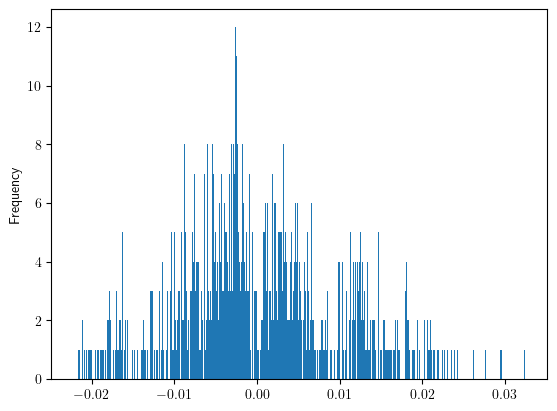

In [10]:
residuals:pd.DataFrame = test_data['EVRG'] - gamma * test_data['CMS'] - mu
adfuller(residuals)
residuals.plot.hist(bins=1000)

#### Optimum threshold

(-7.452384921821468, 312.8587723619657)

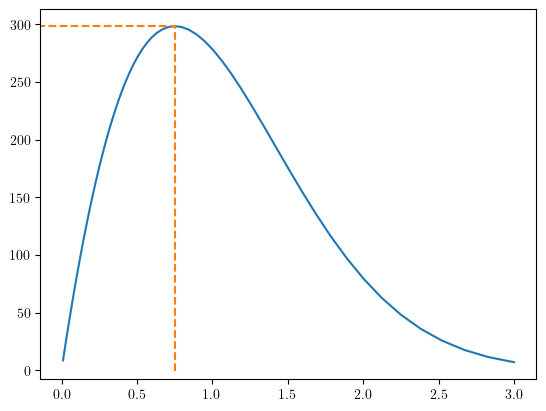

In [11]:
x = np.geomspace(0.01,3,100)
y = x * len(residuals) * (1 - stats.norm.cdf(x))
plt.plot(x,y)
amax = np.argmax(y)
xlim,ylim = plt.xlim(), plt.ylim()
plt.plot([x[amax], x[amax], xlim[0]], [xlim[0], y[amax], y[amax]],
          linestyle="--")
plt.xlim(xlim)
plt.ylim(ylim)

/var/folders/jr/0bg6njgs6rs81lwz018d85bm0000gn/T/ipykernel_45618/1206554441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['spread'] = test_data['CMS'] - test_data['EVRG']


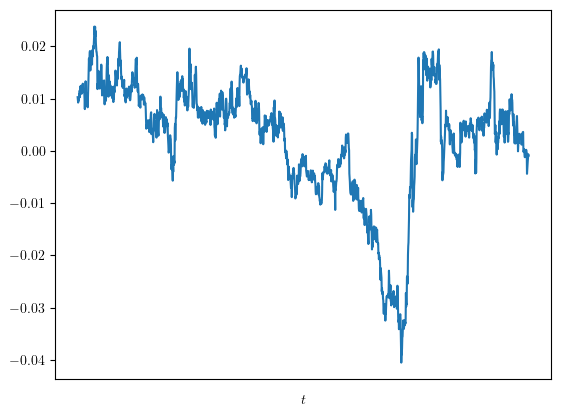

In [13]:
test_data['spread'] = test_data['CMS'] - test_data['EVRG']
fig,ax = plt.subplots()
ax.set_xticklabels([])
ax.tick_params(bottom=False)
ax.set_xlabel(r'$t$')
ax.plot(range(len(test_data)),test_data['spread'])

In [14]:
def cmp(a, b):
    return (a > b) ^ (a < b)

def check_zero_crossing(p1,p2):
    return (p1 < 0 and p2 > 0) or (p1 > 0 and p2 < 0)


def profit_check(df,s):
    openLeg = 0.0
    profit = 0.0
    trades = []
    prev = cmp(df['spread'][0],0)
    for i,spread in enumerate(df['spread']):
        if (spread > s  or spread < -s) and openLeg == 0.0:
            openLeg = spread
            trades.append(i)
        if check_zero_crossing(prev,spread):
            profit += abs(openLeg)
            openLeg = 0.0
        prev = spread
    return profit,trades


        
profit_check(test_data,0.01)


(0.08477336701070004, [0, 385, 944, 1094, 1303, 1324, 1606, 1688])

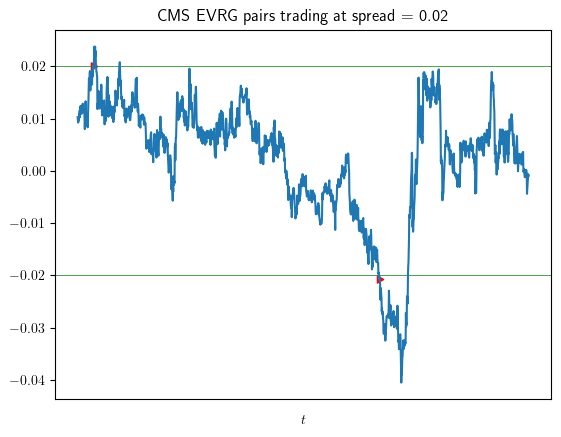

In [25]:
s = 0.02
def spread_entry_plot(test_data,s):
    profit,trades = profit_check(test_data,s)
    fig,ax = plt.subplots()
    ax.set_xticklabels([])
    ax.tick_params(bottom=False)
    ax.set_xlabel(r'$t$')
    ax.axhline(y=s,lw=0.5,c='g')
    ax.axhline(y=-s,lw=0.5,c='g')
    ax.set_title(f"CMS EVRG pairs trading at spread = {s}")
    ax.plot(range(len(test_data)),test_data['spread'])
    ax.scatter(trades,test_data['spread'][trades],marker=(3,0,270),c='red')
spread_entry_plot(test_data,s)

46

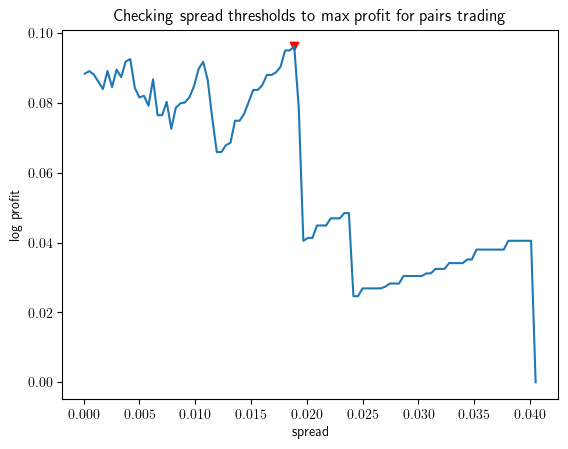

In [24]:
def spread_threshold_plt(test_data):
    max_spread = max(test_data['spread'].abs())
    tests = np.linspace(0.0001,max_spread,100)
    profits,trades = zip(*[profit_check(test_data,t) for t in tests])
    fig,ax = plt.subplots()
    ax.set_title("Checking spread thresholds to max profit for pairs trading")
    ax.set_ylabel('log profit')
    ax.set_xlabel('spread')
    ax.plot(tests,profits)
    top = np.argmax(profits)
    ax.scatter(tests[top],max(profits),marker='v',c='r')
    return top
spread_threshold_plt(test_data)

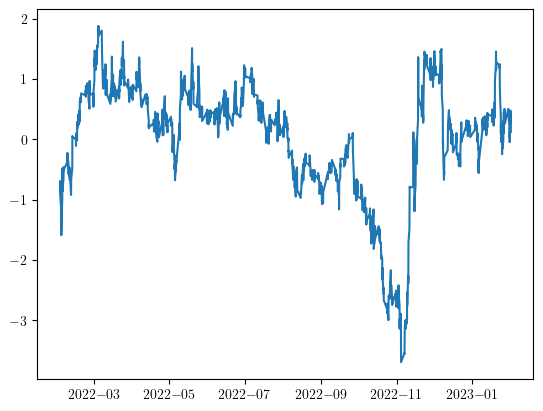

In [255]:
z_score_spread = stats.zscore(test_data['spread'])
fig,ax = plt.subplots()
ax.plot(test_data.index,z_score_spread)